### Import and Setup Packages

In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import time
from babel.dates import format_time
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW

import matplotlib.pyplot as plt

# specify GPU
device = torch.device("cuda")

### Read data

In [2]:
tweet = pd.read_csv("/kaggle/input/sarcasm-preprocessed/tweet_data.csv")
news = pd.read_csv("/kaggle/input/sarcasm-preprocessed/news_data.csv")

In [3]:
tweet = tweet.dropna(subset=['clean_data'])

In [4]:
tweet.isna().sum()

Unnamed: 0             0
clean_data             0
clean_data_ws          6
pos_tagged_data        5
pos                    5
sarcastic              0
sarcasm                0
irony                  0
satire                 0
understatement         0
overstatement          0
rhetorical_question    0
dtype: int64

### Design BERT Model 

In [5]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [7]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
      # dropout layer
        self.dropout = nn.Dropout(0.1)
      
      # relu activation function
        self.relu =  nn.ReLU()

      # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

      #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        

      #pass the inputs to the model  
#       _, cls_hs = self.bert(sent_id, attention_mask=mask)
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

      # output layer
        x = self.fc2(x)
      
      # apply softmax activation
        x = self.softmax(x)

        return x

In [8]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

### Functions to process text data

In [9]:
# Spliting data into train, validation, and test
def data_split(x,y):
    train_text, temp_text, train_labels, temp_labels = train_test_split(x, y, 
                                                                        random_state=2018, 
                                                                        test_size=0.3, 
                                                                        stratify=y)

    # we will use temp_text and temp_labels to create validation and test set
    val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                    random_state=2018, 
                                                                    test_size=0.5, 
                                                                    stratify=temp_labels)
    
    dict = {'train_text' : train_text, 'train_labels' : train_labels, 'val_text' : val_text, 
            'val_labels' : val_labels, 'test_text' : test_text, 'test_labels' : test_labels}
    
    seq_len = [len(i.split()) for i in train_text]

    pd.Series(seq_len).hist(bins = 30)
    
    return dict

In [10]:
# Preparing train, validation and test dataloader
def tokenizer_encoder(data, max_seq_len):
    
    # tokenize and encode sequences in the training set
    tokens_train = tokenizer.batch_encode_plus(
        data['train_text'].tolist(),
        max_length = max_seq_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

    # tokenize and encode sequences in the validation set
    tokens_val = tokenizer.batch_encode_plus(
        data['val_text'].tolist(),
        max_length = max_seq_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

    # tokenize and encode sequences in the test set
    tokens_test = tokenizer.batch_encode_plus(
        data['test_text'].tolist(),
        max_length = max_seq_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )
    
    # for train set
    train_seq = torch.tensor(tokens_train['input_ids'])
    train_mask = torch.tensor(tokens_train['attention_mask'])
    train_y = torch.tensor(data['train_labels'].tolist())

    # for validation set
    val_seq = torch.tensor(tokens_val['input_ids'])
    val_mask = torch.tensor(tokens_val['attention_mask'])
    val_y = torch.tensor(data['val_labels'].tolist())

    # for test set
    test_seq = torch.tensor(tokens_test['input_ids'])
    test_mask = torch.tensor(tokens_test['attention_mask'])
    test_y = torch.tensor(data['test_labels'].tolist())
    
    #define a batch size
    batch_size = 32

    # wrap tensors
    train_data = TensorDataset(train_seq, train_mask, train_y)

    # sampler for sampling the data during training
    train_sampler = RandomSampler(train_data)

    # dataLoader for train set
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # wrap tensors
    val_data = TensorDataset(val_seq, val_mask, val_y)

    # sampler for sampling the data during training
    val_sampler = SequentialSampler(val_data)

    # dataLoader for validation set
    val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
    
    dict = {'train_dataloader' : train_dataloader, 'val_dataloader' : val_dataloader, 'test_seq' : test_seq, 'test_mask' : test_mask, 'test_y' : test_y}
    
    return dict

In [11]:
# Compute loss function
def compute_loss_func(data):
    
    #compute the class weights
    class_wts = compute_class_weight(
        class_weight = 'balanced', 
        classes = np.unique(data['train_labels']), 
        y = data['train_labels']
    )

    print(class_wts)
    
    # convert class weights to tensor
    weights= torch.tensor(class_wts,dtype=torch.float)
    weights = weights.to(device)

    # loss function
    cross_entropy  = nn.NLLLoss(weight=weights) 
    
    return cross_entropy

In [12]:
# function to train the model
def train(train_dataloader, cross_entropy):
    model.train()

    total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
    total_preds=[]
  
  # iterate over batches
    for step,batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

            # push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        
       

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

        # append the model predictions
        total_preds.append(preds)

      # compute the training loss of the epoch
        avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
        total_preds  = np.concatenate(total_preds, axis=0)

      #returns the loss and predictions
        return avg_loss, total_preds

In [13]:
# function for evaluating the model
def evaluate(val_dataloader, cross_entropy):
    print("\nEvaluating...")
  
    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
    total_preds = []

  # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time())
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
      
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [14]:
# function for running the model
def run_model(tokens, data, epochs, cross_entropy):
    # set initial loss to infinite
    best_valid_loss = float('inf')

    # empty lists to store training and validation loss of each epoch
    train_losses=[]
    valid_losses=[]

    #for each epoch
    for epoch in range(epochs):

        print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

        #train model
        train_loss, _ = train(tokens['val_dataloader'], cross_entropy)

        #evaluate model
        valid_loss, _ = evaluate(tokens['val_dataloader'], cross_entropy)

        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'saved_weights_'+data+'.pt')

        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print(f'\nTraining Loss: {train_loss:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')

In [15]:
# function for evaluating model performance
def model_performance(path, tokens):
    
    #load weights of best model
#     path = 'saved_weights.pt'
    model.load_state_dict(torch.load(path))
    
    # get predictions for test data
    with torch.no_grad():
        preds = model(tokens['test_seq'].to(device), tokens['test_mask'].to(device))
        preds = preds.detach().cpu().numpy()
        
    preds = np.argmax(preds, axis = 1)
    report = classification_report(tokens['test_y'], preds)
    print(classification_report(tokens['test_y'], preds))
    
    cm = confusion_matrix(tokens['test_y'], preds)
    print(cm)
      
    return report, cm

### Model training steps

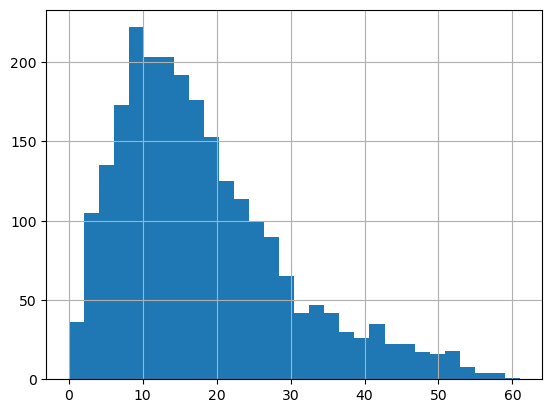

In [16]:
# Splitting the data and Checking the maximum length of text sequences
tweet_split = data_split(tweet['clean_data'], tweet['sarcastic'])

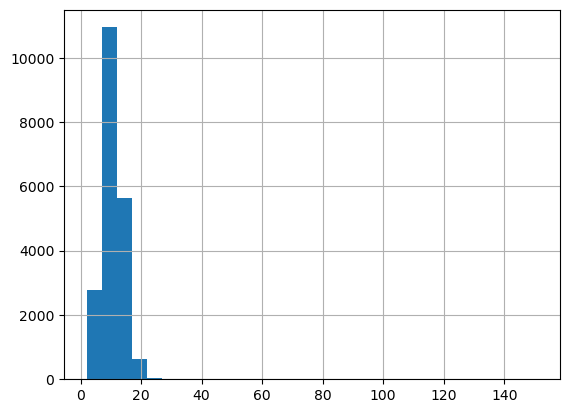

In [17]:
news_split = data_split(news['clean_data'], news['is_sarcastic'])

In [18]:
tweet_tokens = tokenizer_encoder(tweet_split, 60)

In [19]:
news_tokens = tokenizer_encoder(news_split, 30)

In [20]:
tweet_loss = compute_loss_func(tweet_split)

[0.66684992 1.99835255]


In [21]:
news_loss = compute_loss_func(news_split)

[0.95495281 1.04950754]


In [22]:
# number of training epochs
epochs = 100

In [23]:
run_model(tweet_tokens, 'tweet', epochs, tweet_loss)


 Epoch 1 / 100

Evaluating...

Training Loss: 0.040
Validation Loss: 1.122

 Epoch 2 / 100

Evaluating...

Training Loss: 0.052
Validation Loss: 0.879

 Epoch 3 / 100

Evaluating...

Training Loss: 0.043
Validation Loss: 0.694

 Epoch 4 / 100

Evaluating...

Training Loss: 0.039
Validation Loss: 0.691

 Epoch 5 / 100

Evaluating...

Training Loss: 0.040
Validation Loss: 0.704

 Epoch 6 / 100

Evaluating...

Training Loss: 0.038
Validation Loss: 0.781

 Epoch 7 / 100

Evaluating...

Training Loss: 0.039
Validation Loss: 0.825

 Epoch 8 / 100

Evaluating...

Training Loss: 0.042
Validation Loss: 0.781

 Epoch 9 / 100

Evaluating...

Training Loss: 0.039
Validation Loss: 0.715

 Epoch 10 / 100

Evaluating...

Training Loss: 0.037
Validation Loss: 0.697

 Epoch 11 / 100

Evaluating...

Training Loss: 0.040
Validation Loss: 0.696

 Epoch 12 / 100

Evaluating...

Training Loss: 0.040
Validation Loss: 0.702

 Epoch 13 / 100

Evaluating...

Training Loss: 0.038
Validation Loss: 0.738

 Epoch 

In [24]:
run_model(news_tokens, 'news', epochs, news_loss)


 Epoch 1 / 100

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.006
Validation Loss: 0.895

 Epoch 2 / 100

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.006
Validation Loss: 0.938

 Epoch 3 / 100

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.007
Validation Loss: 0.907

 Epoch 4 / 100

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.006
Validation Loss: 0.837

 Epoch 5 / 100

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.006
Validation Loss: 0.840

 Epoch 6 / 100

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.006
Validation Loss: 0.837

 Epoch 7 / 100

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.007
Validation Loss: 0.837

 Epoch 8 / 100

Evaluating...
  Batch    50  of    135.
  Batch   100  of    135.

Training Loss: 0.006

In [25]:
tweet_report, tweet_cm = model_performance('saved_weights_tweet.pt', tweet_tokens)

              precision    recall  f1-score   support

           0       0.74      0.74      0.74       390
           1       0.22      0.22      0.22       130

    accuracy                           0.61       520
   macro avg       0.48      0.48      0.48       520
weighted avg       0.61      0.61      0.61       520

[[289 101]
 [101  29]]


In [26]:
news_report, news_cm = model_performance('saved_weights_news.pt', news_tokens)

              precision    recall  f1-score   support

           0       0.65      0.58      0.62      2248
           1       0.59      0.65      0.62      2045

    accuracy                           0.62      4293
   macro avg       0.62      0.62      0.62      4293
weighted avg       0.62      0.62      0.62      4293

[[1314  934]
 [ 708 1337]]


In [27]:
with open('tweet_report_cm.pkl', 'wb') as f:
    pkl.dump(tweet_report, f)
    pkl.dump(tweet_cm, f)

with open('news_report_cm.pkl', 'wb') as f:
    pkl.dump(news_report, f)
    pkl.dump(news_cm, f)